# Mentoria Data Science Academy

## Imports

In [2]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Downloads do pacote NLTK
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## 0.0 Carregando os Dados

In [3]:
data_path = 'Scrapping/dados'
df1 = pd.read_csv(os.path.join(data_path, 'posts.csv'), sep = '|')
df2 = pd.read_csv(os.path.join(data_path, 'posts_2.csv'), sep = '|')

In [4]:
df = pd.concat([df1, df2], axis = 0)

In [5]:
df.head()

,title,date,answers,visits,url,post,area
0,recurso cabível exceção de preexecutividade re...,11 de Março de 2021,1,1.0,threads/recurso-cabivel-excecao-de-preexecutiv...,"\n\t\t\t\t\t\n\t\t\t\t\tBoas tardes, caros col...",direito-do-trabalho.17
1,Liquidez - Reforma Trabalhista,06 de Março de 2021,0,6.0,threads/liquidez-reforma-trabalhista.23092/,"\n\t\t\t\t\t\n\t\t\t\t\tBoa noite, colegas.\n\...",direito-do-trabalho.17
2,Rito Sumário - sentença irrecorrível?,06 de Março de 2021,0,6.0,threads/rito-sumario-sentenca-irrecorrivel.23091/,"\n\t\t\t\t\t\n\t\t\t\t\tOlá, colegas.\n\nAlgué...",direito-do-trabalho.17
3,DISPENSA DE FUNCIONARIO AFASTADO EM ESPECIE DE...,27 de Janeiro de 2021,0,9.0,threads/dispensa-de-funcionario-afastado-em-es...,"\n\t\t\t\t\t\n\t\t\t\t\tPrezados, Drs.\n\nPrim...",direito-do-trabalho.17
4,Cálculo Trabalhista - contador ou advogado?,03 de Maio de 2018,8,1.0,threads/calculo-trabalhista-contador-ou-advoga...,"\n\t\t\t\t\t\n\t\t\t\t\tQueridos (as),\n\nUm c...",direito-do-trabalho.17


In [6]:
df['area'] = df['area'].apply(lambda x: x.split('.')[0])

## 1.0 Descrição dos dados

### 1.1 Dimensão dos dados

In [7]:
print("Número de exemplos:", df.shape[0])
print("Número de colunas:", df.shape[1])

Número de exemplos: 5826
Número de colunas: 7


### 1.2 Tipo das colunas

In [8]:
# Mostra o tipo de cada variável
df.dtypes

title       object
date        object
answers      int64
visits     float64
url         object
post        object
area        object
dtype: object

### 1.3 Variável target 

### 1.3.1 Classes únicas


In [9]:
# Check de quais classes o dataset possui
df['area'].unique()

array(['direito-do-trabalho', 'direito-de-familia',
       'direito-administrativo',
       'direito-civil-empresarial-e-do-consumidor',
       'direito-penal-e-processo-penal', 'empresarial'], dtype=object)

In [10]:
print("Número de classes diferentes: ", len(df['area'].unique()))

Número de classes diferentes:  6


### 1.3.2 Verificando o balanceamento das classes

In [11]:
# Verifica em porcentagem o balanço das classes
df['area'].value_counts(normalize=True)*100

direito-civil-empresarial-e-do-consumidor    33.882595
direito-de-familia                           28.046687
direito-do-trabalho                          20.116718
direito-penal-e-processo-penal               11.465843
direito-administrativo                        6.316512
empresarial                                   0.171644
Name: area, dtype: float64

**Observações:** As classes empresarial e direito admnistrativo são as que apresentam menos classes.

 ## 2.0 Limpeza dos dados

### 2.1 Visualizando os dados em formato RAW

In [12]:
# Printando as 10 primeiras strings em formato raw
for i, post in enumerate(df['post'][:10]):
    print(repr(df['post'].iloc[i]))
    print('\n')

'\n\t\t\t\t\t\n\t\t\t\t\tBoas tardes, caros colegas\n\nAntes de mais nada, sinto um imenso prazer em visitar esse fórum, por ter me ajudado e muito.\nPreciso da opinião dos colegas, no seguinte assunto trabalhista.\n\nAcontece que a exceção de pre-executividade trabalhista  proposta em favor da cliente fora rejeitada, nesse caso cabe algum recurso....pois segundo uma pesquisa que efetuei, consta que o agravo de petição não é cabível por ser decisão interlocutória, agradeço desde já.\n\t\t\t\t'


'\n\t\t\t\t\t\n\t\t\t\t\tBoa noite, colegas.\n\nCuido de uma ação de cobrança de contribuição sindical rural proposta pelo rito sumário. Por fim o autor requereu: \n\n"a condenação do Réu ao pagamento da quantia atualizada do débito no importe de R$ 835,45 (oitocentos e trinta e cinco reais e quarenta e cinco centavos), referente à Contribuição Sindical Rural do(s) Exercício(s) de 2015, conforme os Demonstrativos da Constituição do Crédito ora inclusos e integrantes desta petição inicial, bem c

## 2.2 Criando um Pipeline de Limpeza

In [13]:
# Essa função substitui mais de um espaço em sequência (\n\t\t\t\t) por apenas um espaço
def remove_seq_breaklines(text):
    clean_text = re.sub('\s{2,}', ' ', text)
    return clean_text

In [14]:
# Essa função substitui \n por um espaço
def remove_breaklines(text):
    clean_text = re.sub('\n', ' ', text)
    return clean_text

In [15]:
def remove_seq_spaces(text):
    clean_text = re.sub('[ ]{2,}', '', text)
    return clean_text

In [16]:
remove_seq_spaces('eu  eu')

'eueu'

In [17]:
# Essa função remove os espaços que existem no fim e no inicio
def remove_spaces(text):
    clean_text = text.strip(' ')
    clean_text
    return clean_text

In [18]:
# Essa função remove as pontuações e os números (ex: datas serão removidas)
def remove_punctuation(text):
    clean_text  = "".join([char for char in text if char not in string.punctuation])
    clean_text = re.sub('[0-9]+', '', clean_text)
    clean_text = clean_text.replace('º', '')
    return clean_text

In [19]:
# Essa função converte textos em textos lowercase 
def convert_to_lower(text):
    return text.lower()

In [20]:
# Essa função remove as stopwords
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    clean_text = [word for word in text.split(' ') if word not in stopwords]
   
    return " ".join(clean_text)


In [21]:
# Essa função aplica o stemming nas palavras
def stemmatization(text):
    stemmer = nltk.stem.RSLPStemmer()
    split_text = text.split(' ')
    stem_text = [stemmer.stem(word) for word in split_text if word != ""]
    stem_text = " ".join(stem_text)
    
    return stem_text

In [22]:
# Função que aplica o pipeline
def run_clean_pipeline(text):
    clean_text = remove_breaklines(text)
    clean_text = remove_seq_breaklines(clean_text)
    clean_text = remove_spaces(clean_text)
    clean_text = remove_punctuation(clean_text)
    clean_text = convert_to_lower(clean_text)
    clean_text = remove_stopwords(clean_text)
    clean_text = stemmatization(clean_text)

    return clean_text
    

In [23]:
# Fazendo a limpeza das linhas através do pipeline
clean_posts = list(df['post'].apply(run_clean_pipeline))

In [24]:
# Printa os 10 primeiras posts após a limpeza
for post in clean_posts[:10]:
    print(post)
    print('\n')

boa tard car coleg ant nad sint imens praz visit fórum ter ajud precis opin coleg seguint assunt trabalh acontec exceç preexecut trabalh propost favor client rejeit ness cas cab algum recursopoil segund pesquis efet const agrav pet cab ser decis interlocutór agradeç desd


boa noit coleg cuid açã cobranç contribu sindic rural propost rit sum fim autor requer conden réu pag quant atual débit import r oitocent trint cinc real quarent cinc centav refer contribu sindic rural exercíci conform demonstr constitu crédit ora inclus integr dest pet inic bem réu conden pag jur mult correç monetár art clt dat efet quit cust process honor advocatíci sobr val conden r cent vint cinc real trint centav val estim bas val caus tend vist após advent reform trabalh inic dev ser líqu ent ped liquid moment proposit val jur correç contas apen part dat ajuiz dia efetiv liquid advent nov red artig parágraf part final pod juiz extrapol val indic inic aplic jur correç pretérit ajuiz grat desd


olá coleg alguém 

In [25]:
df['clean_posts'] = clean_posts

## 3.0 Filtragem dos Dados

No contexto das classes, conforme discutido em reunião, iremos excluir as classes com menos dados:

- direito-administrativo

- empresarial


In [26]:
df = df[(df['area'] != 'empresarial') & (df['area'] != 'direito-administrativo')]

## 3.0 Preparação dos Dados

### 3.1 Split train/test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('area', axis = 1), df['area'], test_size=0.33, shuffle = True, random_state = 42)

### 3.2 Transformação TF-IDF

In [28]:
tfidf_vectorizer = TfidfVectorizer()

train_tfidf = tfidf_vectorizer.fit_transform((X_train['clean_posts'])) 
test_tfidf = tfidf_vectorizer.transform((X_test['clean_posts']))

### 3.3 Codificação por Label

In [30]:
label_enc = {'direito-de-familia':0, 'direito-do-trabalho': 1,'direito-penal-e-processo-penal':2,'direito-civil-empresarial-e-do-consumidor': 3}
y_train = y_train.map(label_enc)
y_test = y_test.map(label_enc)

## 4.0 Modelo de Machine Learning

In [31]:
model = MultinomialNB()
model.fit(train_tfidf, y_train)

MultinomialNB()

In [32]:
ypred_nb = model.predict(test_tfidf)

## 5.0 Avaliação dos Modelos

Optei por utilizar Accuracy, Precision e Kappa Score por ser um problema de classificação multi-classe.

- Accuracy mede o quão bem o modelo está fazendo as previsões.
- Precision mede o quão bem o modelo está fazendo as predições dos True Positives
- Kappa score é uma medida de concordância entre 2 estimadores, no caso, o modelo e o y_test.

### 5.1 Avaliação Individual do Modelo

In [33]:
print('Accuracy:', accuracy_score(y_test, ypred_nb))
print('Precision:', precision_score(y_test, ypred_nb, average = 'macro' ))
print('Kappa Score:', cohen_kappa_score(y_test, ypred_nb))

Accuracy: 0.6868743047830923
Precision: 0.8458495287687156
Kappa Score: 0.5386322782479336


In [34]:
print(classification_report(y_test, ypred_nb))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       540
           1       0.99      0.47      0.63       408
           2       1.00      0.10      0.18       216
           3       0.55      0.92      0.69       634

    accuracy                           0.69      1798
   macro avg       0.85      0.57      0.58      1798
weighted avg       0.79      0.69      0.66      1798



Text(33.0, 0.5, 'True Labels')

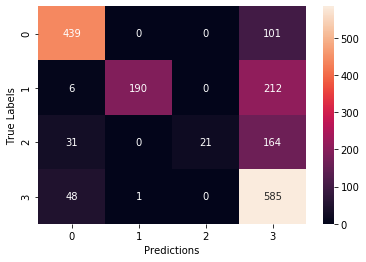

In [35]:
sns.heatmap(confusion_matrix(y_test, ypred_nb),fmt = 'd', annot = True)
plt.xlabel('Predictions')
plt.ylabel('True Labels')

### 5.2 Cross-Validation

In [39]:
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df.drop('area', axis = 1), df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer()

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'])) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts']))
    
    model = MultinomialNB()
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
    

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [40]:
print('Cross-Validation Evaluation:')
print('Accuracy: {:.2f} +/- {:.2f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision: {:.2f} +/- {:.2f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score: {:.2f} +/- {:.2f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation Evaluation:
Accuracy: 0.70 +/- 0.02
Precision: 0.84 +/- 0.01
Kappa Score: 0.56 +/- 0.02


## Sugestões de Melhorias:

- Utilização de Bigramas ou Trigramas antes da transformação TF-IDF com o próprio MultinomialNB
- Utilização de SVM c/ Linear Kernel
- Utilização de Redes Neurais - LSTM
- SMOTE para um melhor balanceamento das classes
- Análise da Nuvem de palavras pra cada classe, a fim de identificar quais termos aparecem com mais frequência dependendo da classe.